This notebook looks at detection of a simple SN Ia model in various survey strategies.


In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db


We look at year=9 at most of the galactic plane etc. work is completed

In [21]:
year = 9


This is a simple SN Ia, z=0.5, stretch=1, colour=0 event from SiFTO. AB mAGS. These peak mags are in DES filters.

At z=0.5, the rise is $18d*(1+z)=27$ and we want to follow the event for about 20 days post max in the rest-frame. But we will never detect in the first few days so we just say we care about the 10 days prior to peak ie a rise of 15d observer frame.

We mock-up the rise as 2 mags over peak time, and the fall as 1.4 mags over 30 observer days in r at z=0.5

In [22]:
# Trying to make a type Ia-like 
peaks = {'uPeak':20.9, 'gPeak':18.6, 'rPeak':18.6, 'iPeak':18.7, 'zPeak':18.7,'yPeak':18.8}

colors = ['b','g','r','purple','y','magenta','k']

filterNames = ['u','g','r','i','z','y']

peakTime = 15
transDuration = 100 # Days
transMetric = metrics.TransientAscii(surveyDuration=1, peakTime=10,
                                        detectfactor={'u':1,'g':1,'r':1,'i':1,'z':1,'y':1},
                                        nFilters=2, nPrePeak=2, nPerLC=1,
                                        #nPrePeak={'u':1,'g':2,'r':3,'i':2,'z':2,'y':1}, nFilters=2,
                                        asciifile={'u':'Iau.nugent.lc','g':'Iag.nugent.lc','r':'Iar.nugent.lc','i':'Iai.nugent.lc','z':'Iaz.nugent.lc','y':'Iay.nugent.lc'},**peaks)


times = np.arange(0.,transDuration*2,1) 
for filterName, color in zip(filterNames,colors):
    filters = np.array([filterName]*times.size)
    lc = transMetric.lightCurve_SV(times ,filters)
    plt.plot(times,lc, color, label=filterName)
plt.xlabel('time (days)')
plt.ylabel('mags')
plt.ylim([35,18])
plt.legend()

AttributeError: 'module' object has no attribute 'TransientAscii'

### What fraction are detected at least once in any filter?


In [4]:
# Pick a slicer
slicer = slicers.HealpixSlicer(nside=64)

summaryMetrics = [metrics.MedianMetric(), metrics.PercentileMetric()]
# Configure some metrics
metricList = []
# What fraction are detected at least once?
metricList.append(transMetric)
#metricList.append(transMetric)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [5]:
# Set the database and query
runName = 'enigma_1189'#'enigma_1189' 
#runName = 'ops1_1160'#'enigma_1189' 
sqlconstraint = 'night between %f and %f and ((filter = "r" or filter = "g" ) OR (filter = "r" or filter = "u" ) or (filter = "i" or filter = "g" ) or (filter = "i" or filter = "u" ))'% ((365.25*year,365.25*(year+0.03)))
bDict={}
for i,metric in enumerate(metricList):
    bDict[i] = metricBundles.MetricBundle(metric, slicer, sqlconstraint, 
                                          runName=runName, summaryMetrics=summaryMetrics)

NOTE - change your path and/or opsim database here

In [6]:
opsdb = db.OpsimDatabase('sqlite:///' + runName + '_sqlite.db')
outDir = 'Transients'
resultsDb = db.ResultsDb(outDir=outDir)

In [7]:
bgroup = metricBundles.MetricBundleGroup(bDict, opsdb, outDir=outDir, resultsDb=resultsDb, verbose=True)

In [8]:
bgroup.runAll()


Querying database with constraint night between 3287.250000 and 3298.207500 and ((filter = "r" or filter = "g" ) OR (filter = "r" or filter = "u" ) or (filter = "i" or filter = "g" ) or (filter = "i" or filter = "u" ))
Found 5885 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting.
monopole: 0.0161594  dipole: lon: -110.727, lat: -61.8403, amp: 0.0153705
Plotting complete.


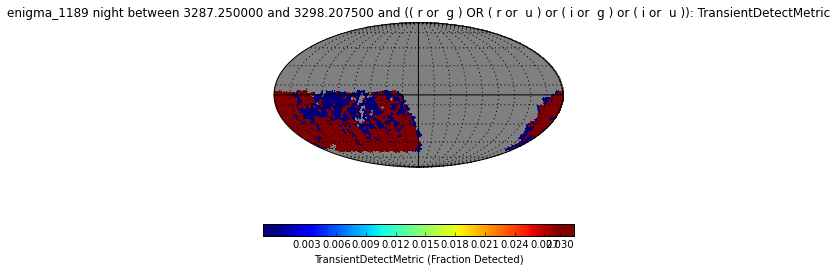

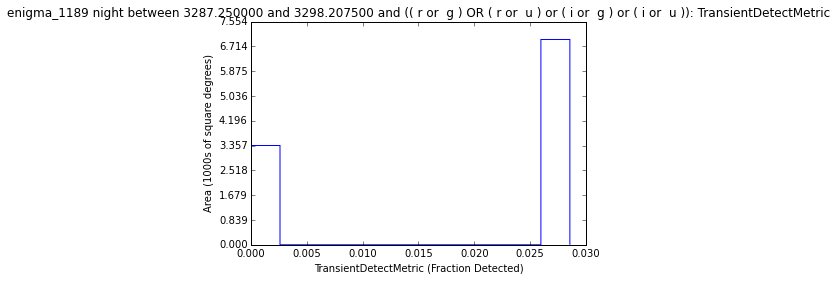

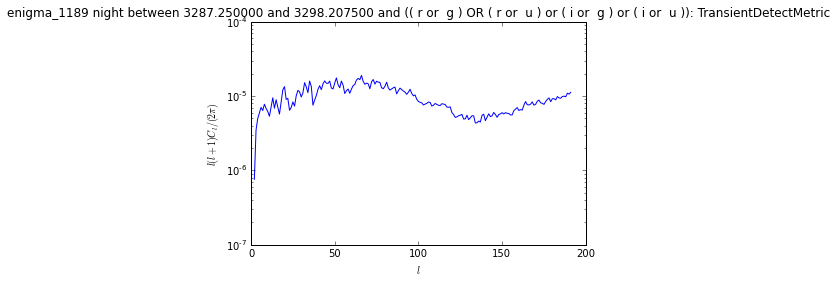

In [9]:
bgroup.plotAll(closefigs=False)

In [10]:
bgroup.writeAll()
print bgroup.outDir

Re-saving metric bundles.
Transients


In [11]:
for key in bDict:
    bDict[key].computeSummaryStats(resultsDb=resultsDb)
    print bDict[key].metric.name, bDict[key].summaryValues

TransientDetectMetric {'90th%ile': 0.028571428571428574, 'Median': 0.028571428571428571}


### What fraction are detected at least 6 times in one of g r i z, 3 in first half, 3 in second half


In [12]:
transMetric = metrics.TransientMetric(riseSlope= -2./peakTime, declineSlope=1.4/30., 
                                      transDuration=transDuration, peakTime=peakTime, surveyDuration=1, 
                                      nFilters=3, nPrePeak=3, nPerLC=2, **peaks)

sqlconstraint = '(filter="r" or filter="g" or filter="i" or filter="z") and night between %f and %f' % (365.25*year,365.25*(year+0.1))
transBundle = metricBundles.MetricBundle(transMetric, slicer, sqlconstraint, 
                                          runName=runName, summaryMetrics=summaryMetrics)

In [13]:

bgroup = metricBundles.MetricBundleGroup({0:transBundle}, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()

Querying database with constraint (filter="r" or filter="g" or filter="i" or filter="z") and night between 3287.250000 and 3323.775000
Found 17985 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


/Users/fbianco/lsst/DarwinX86/sims_maf/1.0.2+21/python/lsst/sims/maf/utils/mafUtils.py:60: RuntimeWarning: invalid value encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
Optimal bin calculation calculated NaN: returning 200
Only one metric value, making a guess at a good histogram range.
/Users/fbianco/lsst/DarwinX86/healpy/1.8.1+6/lib/python/healpy-1.8.1-py2.7-macosx-10.5-x86_64.egg/healpy/rotator.py:474: RuntimeWarning: invalid value encountered in double_scalars
  ang[0, :] = np.arccos(vz / r)


Plotting.
monopole: 0  dipole: lon: 0, lat: nan, amp: 0
Plotting complete.


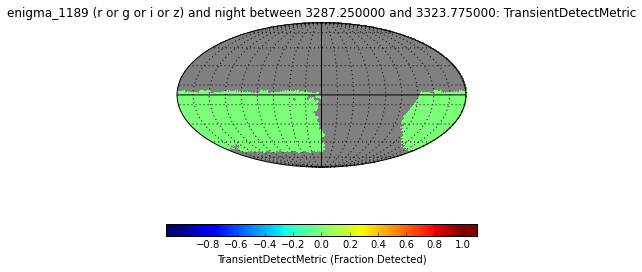

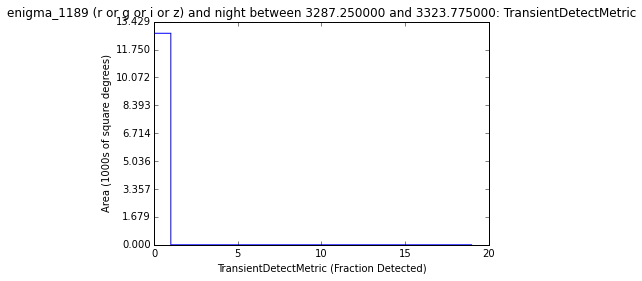

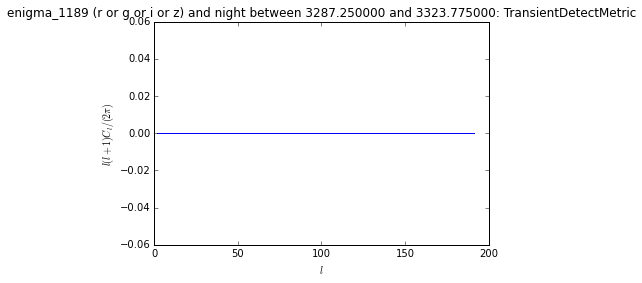

In [14]:
bgroup.plotAll(closefigs=False)


Keywords that we need to add:

* Total number of points
* Gap time to demand between points in the same filter to count them as independent

### What fraction are detected at least 9 times in one of g r i z, 3 in each third

In [15]:
transMetric = metrics.TransientMetric(riseSlope= -2./peakTime, declineSlope=1.4/30., 
                                      transDuration=transDuration, peakTime=peakTime, surveyDuration=1, 
                                      nFilters=3, nPrePeak=3, nPerLC=3, **peaks)

sqlconstraint = '(filter="r" or filter="g" or filter="i" or filter="z") and night between %f and %f'% (365.25*year,365.25*(year+1))
transBundle = metricBundles.MetricBundle(transMetric, slicer, sqlconstraint, 
                                          runName=runName, summaryMetrics=summaryMetrics)

Querying database with constraint (filter="r" or filter="g" or filter="i" or filter="z") and night between 3287.250000 and 3652.500000
Found 172989 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting.
monopole: 0.18113  dipole: lon: 176.461, lat: -35.2165, amp: 0.038911
Plotting complete.


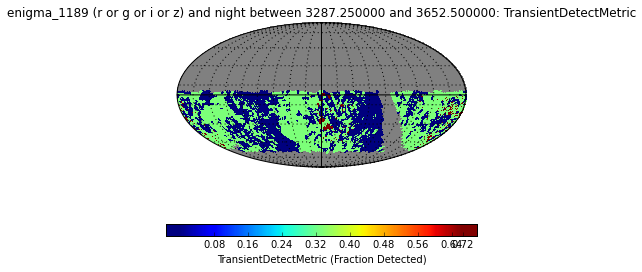

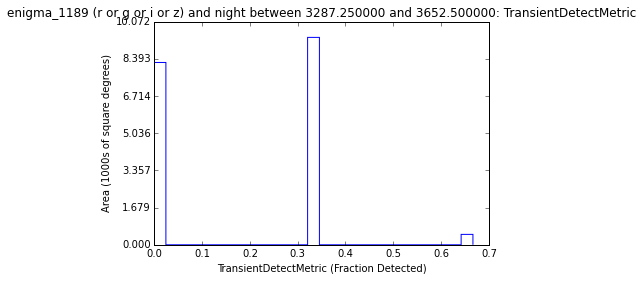

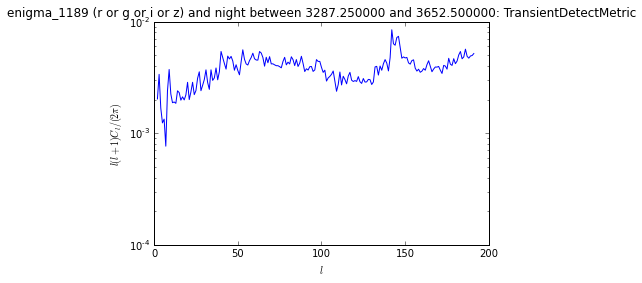

In [16]:
bgroup = metricBundles.MetricBundleGroup({0:transBundle}, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)


In [17]:
class ExtractLC(metrics.TransientMetric):
    """
    Be identical to the Transient Metric, but just save the light curves that
    meet the criteria.
    """
    def run(self, dataSlice, slicePoint=None):

        # Total number of transients that could go off back-to-back
        nTransMax = np.floor(self.surveyDuration/(self.transDuration/365.25))
        tshifts = np.arange(self.nPhaseCheck)*self.transDuration/float(self.nPhaseCheck)
        nDetected = 0
        nTransMax = 0
        for tshift in tshifts:
            # Compute the total number of back-to-back transients are possible to detect
            # given the survey duration and the transient duration.
            nTransMax += np.floor(self.surveyDuration/(self.transDuration/365.25))
            if tshift != 0:
                nTransMax -= 1
            if self.surveyStart is None:
                surveyStart = dataSlice[self.mjdCol].min()
            time = (dataSlice[self.mjdCol] - surveyStart + tshift) % self.transDuration

            # Which lightcurve does each point belong to
            lcNumber = np.floor((dataSlice[self.mjdCol]-surveyStart)/self.transDuration)

            lcMags = self.lightCurve(time, dataSlice[self.filterCol])

            # How many criteria needs to be passed
            detectThresh = 0

            # Flag points that are above the SNR limit
            detected = np.zeros(dataSlice.size, dtype=int)
            detected[np.where(lcMags < dataSlice[self.m5Col] + self.detectM5Plus)] += 1
            detectThresh += 1

            # If we demand points on the rise
            if self.nPrePeak > 0:
                detectThresh += 1
                ord = np.argsort(dataSlice[self.mjdCol])
                dataSlice = dataSlice[ord]
                detected = detected[ord]
                lcNumber = lcNumber[ord]
                time = time[ord]
                ulcNumber = np.unique(lcNumber)
                left = np.searchsorted(lcNumber, ulcNumber)
                right = np.searchsorted(lcNumber, ulcNumber, side='right')
                # Note here I'm using np.searchsorted to basically do a 'group by'
                # might be clearer to use scipy.ndimage.measurements.find_objects or pandas, but
                # this numpy function is known for being efficient.
                for le,ri in zip(left,right):
                    # Number of points where there are a detection
                    good = np.where(time[le:ri] < self.peakTime)
                    nd = np.sum(detected[le:ri][good])
                    if nd >= self.nPrePeak:
                        detected[le:ri] += 1

            # Check if we need multiple points per light curve or multiple filters
            if (self.nPerLC > 1) | (self.nFilters > 1) :
                # make sure things are sorted by time
                ord = np.argsort(dataSlice[self.mjdCol])
                dataSlice = dataSlice[ord]
                detected = detected[ord]
                lcNumber = lcNumber[ord]
                ulcNumber = np.unique(lcNumber)
                left = np.searchsorted(lcNumber, ulcNumber)
                right = np.searchsorted(lcNumber, ulcNumber, side='right')
                detectThresh += self.nFilters

                for le,ri in zip(left,right):
                    points = np.where(detected[le:ri] > 0)
                    ufilters = np.unique(dataSlice[self.filterCol][le:ri][points])
                    phaseSections = np.floor(time[le:ri][points]/self.transDuration * self.nPerLC)
                    for filtName in ufilters:
                        good = np.where(dataSlice[self.filterCol][le:ri][points] == filtName)
                        if np.size(np.unique(phaseSections[good])) >= self.nPerLC:
                            detected[le:ri] += 1


        return {'lcNumber':lcNumber, 'lcMag':lcMag, 'detected':detected,
                'time':time, 'detectThresh':detectThresh, 'filter':dataSlice[self.filterCol]}


In [18]:
lcM = ExtractLC(riseSlope= -2.3/peakTime, declineSlope=1.6/30., 
                                      transDuration=transDuration, peakTime=peakTime, surveyDuration=1, 
                                      nFilters=3, nPrePeak=3, nPerLC=2, **peaks)

sqlconstraint = '(filter="r" or filter="g" or filter="i" or filter="z") and night between %f and %f and fieldRA < ? and fieldDec > ? ' % (365.25*year,365.25*(year+1))
transBundle = metricBundles.MetricBundle(transMetric, slicer, sqlconstraint, 
                                          runName=runName, summaryMetrics=summaryMetrics)

In [19]:
bgroup = metricBundles.MetricBundleGroup({0:transBundle}, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)



Querying database with constraint (filter="r" or filter="g" or filter="i" or filter="z") and night between 3287.250000 and 3652.500000 and fieldRA < ? and fieldDec > ? 


ProgrammingError: (ProgrammingError) Incorrect number of bindings supplied. The current statement uses 2, and there are 0 supplied. u'SELECT min("Summary"."obsHistID") AS "obsHistID", min("Summary".filter) AS filter, min("Summary"."fieldRA") AS "fieldRA", min("Summary"."fiveSigmaDepth") AS "fiveSigmaDepth", min("Summary"."fieldDec") AS "fieldDec", min("Summary"."expMJD") AS "expMJD" \nFROM "Summary" \nWHERE (filter="r" or filter="g" or filter="i" or filter="z") and night between 3287.250000 and 3652.500000 and fieldRA < ? and fieldDec > ?  GROUP BY "Summary"."expMJD"' ()